In [1]:
import json
import time
import os

from pymongo import MongoClient

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

client = MongoClient("localhost", 27017)
db = client['usgs']

%matplotlib inline

In [2]:
def align_measurements(t_meas, y_meas, t_corr, y_corr):
    dt_corr, n_corr = np.unique(t_corr[1:] - t_corr[:-1], return_counts=True)
    dt_meas, n_meas = np.unique(t_meas[1:] - t_meas[:-1], return_counts=True)
    dt = min(dt_corr[np.argmax(n_corr)], dt_meas[np.argmax(n_meas)])
    
    offset_corr = max(t_corr[0] - t_meas[0], 0)
    offset_meas = max(t_meas[0] - t_corr[0], 0)
    N = (max(t_corr[-1], t_meas[-1]) - min(t_corr[0], t_meas[0])) // dt + 1
    
    y_corr_new = np.zeros(N) - 1
    y_meas_new = np.zeros(N) - 1
    
    idx_corr = np.cumsum((t_corr[1:] - t_corr[:-1]) // dt) + offset_corr // dt
    idx_meas = np.cumsum((t_meas[1:] - t_meas[:-1]) // dt) + offset_meas // dt
    
    y_corr_new[idx_corr] = y_corr[1:]
    y_meas_new[idx_meas] = y_meas[1:]
    
    y_corr_new[0] = y_corr[0]
    y_meas_new[0] = y_meas[0]
    
    return y_meas_new, y_corr_new


def mark_anomaly(y_m, y_c, anomaly_thresh):
    return np.logical_or(y_c < 0, np.abs(y_c - y_m) > anomaly_thresh)   

In [3]:
sites = db['cites']
measured = db['measured']
corrected = db['corrected']

cursor = sites.find()
sid = [c['site_no'] for c in cursor]

In [12]:
impurity = list() 
i = 0
for si in range(cursor.count()):
    datam = measured.find_one({'site_no': sid[si]})
    if datam is None:
        continue
    t_meas = np.array(datam['utc'], dtype=np.int32)
    z_meas = np.array(datam['gh'],  dtype=np.float32)

    datac = corrected.find_one({'site_no': sid[si]})
    if datac is None:
        continue
    t_corr = np.array(datac['utc'], dtype=np.int32)
    z_corr = np.array(datac['gh'],  dtype=np.float32)

    y_m, y_c = align_measurements(t_meas, z_meas, t_corr, z_corr)

    abs_thresh = 200
    y_m[np.where(y_m <= 0)[0]] = -1
    y_m[np.where(y_m > abs_thresh)[0]] = -1
    
    impurity.append((np.sum(y_m <= 0) / y_m.size, np.sum(y_c <= 0) / y_c.size, y_m.size, sid[si]))
    if i % 10 == 0:
        print(i, y_m.size)
    i += 1

#is_outlier = mark_anomaly(y_m, y_c, 0.05)

0 130029
10 130023
20 130037
30 130030
40 130021
50 130027
60 130027
70 130020
80 130024
90 130032
100 130029
110 130028
120 130024
130 130004
140 130023
150 130017
160 130025
170 130030
180 130031
190 65012
200 130031
210 65014
220 130027
230 32507
240 130025
250 130025
260 130026
270 130032
280 130021
290 67189
300 130031
310 130022
320 130019
330 130025
340 130029
350 130032
360 130023
370 130030
380 130022
390 130037
400 130028
410 130025
420 130021
430 130018
440 112294
450 130032
460 130049
470 130028
480 130017
490 32507
500 130026


In [145]:
z = [t[0] for t in impurity]
w = [t[1] for t in impurity]

sorted(impurity)[-28]

(0.1381965006729475, 0.13430494135743126, 130025, 5379500)

(0.083571736188015264, 0.083302571674664691, 130032, 3183500)


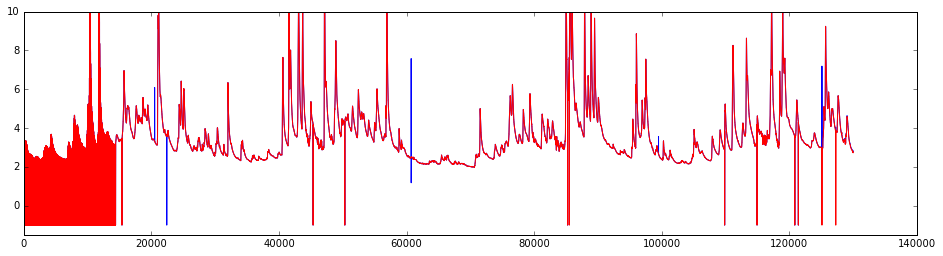

In [176]:
si = sorted(impurity)[-41]

datam = measured.find_one({'site_no': si[3]})
t_meas = np.array(datam['utc'], dtype=np.int32)
z_meas = np.array(datam['gh'],  dtype=np.float32)

datac = corrected.find_one({'site_no': si[3]})
t_corr = np.array(datac['utc'], dtype=np.int32)
z_corr = np.array(datac['gh'],  dtype=np.float32)

y_m, y_c = align_measurements(t_meas, z_meas, t_corr, z_corr)

abs_thresh = 200
y_m[np.where(y_m <= 0)[0]] = -1
#y_m[np.where(y_m > abs_thresh)[0]] = -1

plt.figure(figsize = (16,4))
plt.plot(y_m, 'b-')
plt.plot(y_c, 'r-')
plt.ylim(-1.5, 10)
#plt.xlim(0,1000)

print(si)

In [ ]:
k = 256
step = k // 2
m = k // 2 + 1
n = y_m.size // step + 1
spectrogram = np.zeros((m, n))

for i in range(0, y_m.size - 2*step, step):
    amp = np.abs(np.fft.rfft(y_m[i:i+k]))
    spectrogram[:,i // step] = amp

plt.figure(figsize=(16,4))
plt.imshow(np.log(1 + np.flipud(spectrogram)), aspect='auto')

In [ ]:
plt.figure(figsize = (16,4))
plt.plot(y_m)
plt.xlim(0, y_m.size)

In [ ]:
abs_thresh = 200

y_m[np.where(y_m <= 0)[0]] = -1
y_m[np.where(y_m > abs_thresh)[0]] = -1

dy = np.hstack([y_m[1:] - y_m[:-1], 0])
ddy = np.hstack([0, dy[1:] - dy[:-1]])

# max_dy = np.zeros(dy.size)
# k = 10
# for j in range(k, dy.size):
#     max_dy[j] = np.max(np.abs(dy[j-k:j]))

plt.figure(figsize = (16,6))

plt.title('Site ID %i' % sid[si])
plt.plot(y_m, 'b-')
plt.plot(y_c, 'r-')

z = np.convolve(y_m, [-1,2,-1], mode='same')

#plt.plot(np.arange(y_c.size)[is_outlier], y_c[is_outlier], 'r.')
#plt.plot(z, 'r-')
# plt.plot()
plt.legend(['Measured', 'Fixed'])

plt.grid()
plt.ylim(2.5,3.5)
#plt.xlim(10000,20000)

In [ ]:
e = y_c - y_m
plt.hist(e[np.abs(e) < 1]);